### <span style="color:rgb(237,127,16)">Optimisation-RO</span>

### <span style="color:rgb(237,127,16)">Certificat chef de projet IA, Université Paris Dauphine-PSL, 2022-2023</span>


# <span style="color:rgb(237,127,16)">Lab 2 - Descente de gradient</span>

Pour tout commentaire concernant ce notebook (y compris les typos), merci d'envoyer un mail à **clement.royer@lamsade.dauphine.fr**.



# <span style="color:rgb(237,127,16)">Introduction</span>

Dans ce notebook, nous allons explorer différents algorithmes pour l'optimisation douce ou lisse, basés sur la descente de gradient. 

La première partie de ce notebook s'intéresse à un problème de régression linéaire sur lequel on applique l'algorithme de descente de gradient. Dans la seconde, on illustre un résultat récente de convergence presque sûre de la descente de gradient vers un minimum local. Enfin, dans une dernière partie, on se penche sur un problème matriciel non convexe est étudié.


*Note : Si les différentes parties de ce notebook sont construites de sorte à être indépendantes, les blocs sont fait pour être exécutés de manière séquentielle. On prendra notamment soin d'exécuter le bloc ci-dessous (qui importe des bibliothèques et fonctions utiles) en premier.*

In [1]:
# Imports des bibliothèques et fonctions utiles
###############################################

# Affichage
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Racine carrée

# NumPy - Structures vectorielles et matricielles
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn, uniform, choice # distributions de probabilité

# SciPy - Calculs mathématiques efficaces
from scipy.linalg import norm # normes classiques
from scipy.linalg.special_matrices import toeplitz # matrices de Toeplitz
from scipy.linalg import svdvals # décomposition en valeurs singulières
from scipy.optimize import check_grad # Vérification des dérivées
from scipy.optimize import fmin_l_bfgs_b # Méthode de minimisation efficace

Ce notebook utilise des routines des bibliothèques NumPy and Scipy *(sur Google Colab par défaut, à installer sur votre distribution locale).* Voici un lien vers un bon [tutoriel Numpy (en anglais](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

**Fonctions NumPy utiles (cf documentation pour plus d'informations)**

* *transpose* transposée de matrice (i.e. tableau NumPy bi-dimensionnel). On peut aussi utiliser X.T
* *matmul* produit matrice-matrice (les dimensions doivent être compatibles).
* *dot* produit matrice-vector (si les dimensions sont compatibles), aussi utilisable comme opérateur de produit scalaire entre deux vecteurs de même taille.
* *np.ones((m,n))* matrice de taille m x n avec composantes égales à 1. 
* *np.zeros((m,n))* matrice de taille m x n avec composantes égales à 0.
* *np.identity(n)* matrice identité de taille n x n.
* *np.pi* $\pi$.
* *np.inf* nombre infini en mémoire.
* *np.log* logarithme appliqué à chaque coordonnée des tableaux NumPy.
* *np.exp* exponentielle appliquée à chaque coordonnée des tableaux NumPy.
* *np.sum* somme des composantes d'un tableau NumPy (pour les matrices, somme selon une dimension)
* *np.maximum(u,v)* renvoie un tableau NumPy array dont les composantes sont $max(u_i,v_i)$, si $u_i$ et $v_i$ sont celles de $u$ et $v$.
* *np.concatenate* concatène des tableaux NumPy (vecteurs, matrices) de dimensions compatibles.
* Si t est un tableau NumPy, la fonction *t.shape* renvoie les dimension(s) de ce tableau (utile lorsque l'on cherche à définir un tableau avec les mêmes dimensions.)

# <span style="color:rgb(199,21,11)">Partie 1 - Descente de gradient et moindres carrés</span>

## <span style="color:rgb(199,21,11)">1.1 Génération des données</span>

Soit un jeu de données $\{(\mathbf{a}_i,b_i)\}_{i=1,\dots,n}$, où $\mathbf{a}_i \in \mathbb{R}^d$ et $b_i \in \mathbb{R}$, que l'on met sous la forme

- d'une matrice de caractéristiques (features) $\mathbf{A} \in \mathbb{R}^{n \times d}$;
- et d'un vecteur de labels $\mathbf{b} \in \mathbb{R}^n$. 

Le jeu de données sera produit en utilisant la procédure ci-dessous, qui vise à générer des échantillons avec 
bruit et corrélation contrôlés.

In [2]:
# Ce code est bassé sur un générateur proposé par Alexandre Gramfort de l'INRIA.
def simu_lin(x, n, std=1., corr=0.5):
    """
    Génération de données issues d'un modèle linéaire.
    
    Paramètres
    ----------
    x : np.ndarray, shape=(d,)
        Coefficients du modèle
    
    n : int
        Taille de l'échantillon
    
    std : float, default=1.
        Ecart-type du bruit

    corr : float, default=0.5
        Corrélation de la matrice des caractéristiques
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

Les données seront ainsi produites à partir d'une tendance linéaire à laquelle on rajoutera un bruit gaussien.

## <span style="color:rgb(199,21,11)">1.2 Modèle linéaire et moindres carrés</span>

Notre objectif est de construire un modèle linéaire qui colle au plus près à nos données. Partant de $(\mathbf{A},\mathbf{b})$, on cherche ainsi $\mathbf{x} \in \mathbb{R}^d$ tel que $\mathbf{A} \mathbf{x} -\mathbf{b} \approx 0$.

Sans a priori sur la nature du bruit dont les observations sont entachées (ou en supposant que ce bruit est gaussien), on peut formuler notre objectif comme un problème aux moindres carrés linéaires :
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} 
    f(\mathbf{x}) := \frac{1}{2 n} \|\mathbf{A} \mathbf{x} - \mathbf{b}\|^2 
    = \frac{1}{2n} \sum_{i=1}^n (\mathbf{a}_i^T \mathbf{x} - b_i)^2.
$$ 

### <span style="color:rgb(199,21,11)">Etude du problème</span>

- On observe que toute valeur inférieure ou égale à $0$ est une borne inférieure sur $f$ puisque $f$ ne prend que des valeurs positives ou nulles. La valeur $0$ *peut être* la valeur optimale (càd $0 = \min_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x})$) mais cela dépendra de s'il existe ou non un vecteur $\mathbf{x}^*$ tel que $\mathbf{A} \mathbf{x}^* = \mathbf{b}$.

- Le problème peut se réécrire comme un *problème d'optimisation quadratique* de la forme
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} \frac{1}{2}\mathbf{x}^T \mathbf{H} \mathbf{x} - \mathbf{g}^T \mathbf{x} + c.
$$
avec $\mathbf{H} = \tfrac{\mathbf{A}^T \mathbf{A}}{n}$, $\mathbf{g} = \mathbf{A}^T \mathbf{b}$ et $c=\frac{\mathbf{b}^T \mathbf{b}}{n}$.

- La fonction objectif est de classe $\mathcal{C}^1$ (car polynomiale en chacune des variables), et son gradient est donné par
$$
    \nabla f(\mathbf{x}) 
    = \mathbf{H} \mathbf{x} - \mathbf{g} 
    = \frac{1}{n}\left( \mathbf{A}^T \mathbf{A} \mathbf{x} - \mathbf{A}^T \mathbf{b}\right).
$$
De plus, pour tous $(\mathbf{v},\mathbf{w})$, on a
$$
    \| \nabla f(\mathbf{v}) - \nabla f(\mathbf{w}) \| 
    \le \| \mathbf{H} (\mathbf{v}-\mathbf{w}) \| 
    \le \|\mathbf{H} \| \|\mathbf{v} -\mathbf{w}\|,
$$
où la dernière inégalité provient de l'inégalité de Cauchy-Schwarz et $\|\mathbf{H}\| = \max_{\mathbf{u} \neq 0} \tfrac{\|\mathbf{H}\mathbf{u}\|}{\|\mathbf{u}\|}$. Par conséquent, la fonction $f$ est de classe $\mathcal{C}^{1,1}_{\|\mathbf{H}\|}$, avec $\|\mathbf{H}\| = \tfrac{1}{n}\|\mathbf{A}^T \mathbf{A}\|$.

### <span style="color:rgb(199,21,11)">Classe Python pour le problème de régression linéaire</span>

Le code ci-dessous génère des instances de problèmes de régression linéaire. 

*Note :* Pour tout tableau NumPy X, X.dot(v) est le produit matrice-vecteur $X v$ si $X$ est une matrice, ou le produit scalaire $x^T v$ s'il s'agit d'un vecteur, et X.T renvoie la matrice transposée $X^T$.

In [3]:
# Classe Python pour les problèmes de régression linéaire
class LinReg(object):
    '''
        Problèmes de régression linéaire sous forme de moindres carrés linéaires.
        
        Attributs:
            A: Tableau à deux dimensions, matrice de données (caractéristiques)
            b: Tableau à une dimension, vecteur de données (labels/mesures/...)
            n,d: Dimensions du problème (A de taille n x d, b est de taille n)
            
        Méthodes:
            fun: Calcule la valeur de la fonction objectif pour les moindres carrés linéaires.
            grad: Calcule la valeur du gradient pour les moindres carrés linéaires.
            lipgrad: Calcule la valeur de la constante de Lipschitz pour le gradient.
    '''   

    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
    
    # Fonction objectif
    def fun(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) 
    
    # Gradient
    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n 

    # Constante de Lipschitz pour le gradient
    def lipgrad(self):
        L = norm(self.A, ord=2) ** 2 / self.n # Calcul plus économe de ||A^T A||
        return L 

### <span style="color:rgb(199,21,11)">Génération du problème</span>

**On valide l'implémentation ci-dessus en générant une instance.** L'appel à la fonction *check_grad*, qui vérifie la correspondance entre une fonction et sa dérivée, doit renvoyer une valeur de l'ordre de $10^{-6}$.

In [4]:
# Dimensions 
d = 50
n = 1000
idx = np.arange(d)

# Fixer la configuration du generateur de nombres aleatoires
np.random.seed(1)

# Vérité terrain - Les coefficients de w décroissent de manière exponentielle
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

# Génération de la matrice et du vecteur de données
A,b = simu_lin(x_model_truth, n, std=1., corr=0.1)

# Génération de l'instance correspondante
pblinreg = LinReg(A, b)

# Vérification des formules, et de la cohérence fonction/gradient<
# Si correct, renvoie une valeur de l'ordre de 10^(-6) 
check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d))

1.9057353729057355e-06

On travaille ici avec un problème de dimensions modérées, ce qui nous permet de calculer une solution quasi exacte au moyen d'une méthode d'optimisation non linéaire avancée (L-BFGS dans notre cas) 

In [5]:
# On utilise L-BFGS afin de trouver une approximation précise de la solution au problème

x_init = np.zeros(d)
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

0.4737086058623297
4.81489075811467e-10


## <span style="color:rgb(199,21,11)">1.2 Descente de gradient</span>

L'algorithme de descente de gradient appliqué à une fonction $f$ est défini par un point initial $w_0$ ainsi que 
par l'itération
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla f(\mathbf{w}_k),
$$

**On implémente la descente de gradient avec trois choix de longueurs de pas possibles:**

- $\alpha_k = \frac{1}{L}$, avec $L$ la constante de Lipschitz pour $\nabla f$;

- $\alpha_k = \frac{\alpha_0}{k+1}$;

- $\alpha_k = \frac{\alpha_0}{\sqrt{k+1}}$.

In [6]:
# Descente de gradient
def grad_desc(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000, verbose=False): 
    """
        Un code pour la descente de gradient sur problèmes structurés avec différents choix de 
        longueurs de pas.
        
        Entrées:
            x0: Vecteur initial
            problem: Structure représentant le problème
                problem.fun(x) Fonction objectif
                problem.grad(x) Gradient
                problem.lipgrad() Constante de Lipschitz du gradient
            xtarget: Valeur cible pour le minimum
            stepchoice: Stratégie pour la longueur de pas (see above)
                0: Constante égale à 1/L
                1: Décroissante en 1/(k+1)
                2: Décroissante en 1/sqrt(k+1)
            step0: Longueur de pas initiale (utile si stepchoice = 1)
            n_iter: Nombre maximum d'itérations
            verbose: Booléen réglant l'affichage des informations à chaque itération
      
        Sorties:
            x_output: Itéré final de la méthode
            objvals: Historique des valeurs de fonctions (tableau Numpy de taille n_iter)
            normits: Historique des distances entre itérés et point cible (tableau Numpy de taille n_iter)
            
    """
    
    ############
    # Initialisation

    # Historique des valeurs
    objvals = []
    
    # Distances entre itérés et point cible
    normits = []
    
    # Constante de Lipschitz
    L = problem.lipgrad()
    
    # Valeur initiale de l'itéré courant   
    x = x0.copy()

    # Initialisation du compteur d'itérations
    k=0    
    
    # Fonction objectif en le point courant
    obj = problem.fun(x) 
    objvals.append(obj);
    # Distance courante à l'optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)

    # Affichage des valeurs initiales 
    if verbose:
        print("Descente de gradient :")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ####################
    # Boucle principale
    while (k < n_iter):
        
        # Calcul du gradient
        g = problem.grad(x)
        
        # Choix de la longueur de pas
        if stepchoice==0:
            x[:] = x - (1/L) * g
        elif stepchoice==1:
            x[:] = x - (step0/(k+1))*g
        else:
            x[:] = x - (step0/(sqrt(k+1)))*g
        
        
        # Calcul des nouvelles informations
        obj = problem.fun(x)
        objvals.append(obj)
        nmin = norm(x-xtarget)
        normits.append(nmin)
        
        # Affichage si demandé
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
        
        # Incrémentation
        k += 1
    
    # Fin boucle principale
    ######################
    
    # Informations de sortie
    x_output = x.copy()
    return x_output, np.array(objvals), np.array(normits)

**Comparer les trois variantes en faisant tourner les scripts ci-dessous.**

In [7]:
# Tester trois variantes de descente de gradient
x0 = np.zeros(d)
x_a, obj_a, nits_a = grad_desc(x0,pblinreg,x_min_lin,stepchoice=0,step0=1, n_iter=100)
x_b, obj_b, nits_b = grad_desc(x0,pblinreg,x_min_lin,stepchoice=1,step0=1, n_iter=100)
x_c, obj_c, nits_c = grad_desc(x0,pblinreg,x_min_lin,stepchoice=2,step0=1, n_iter=100)

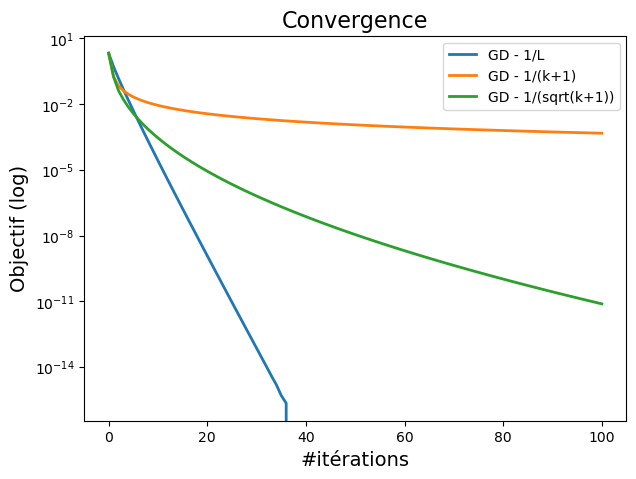

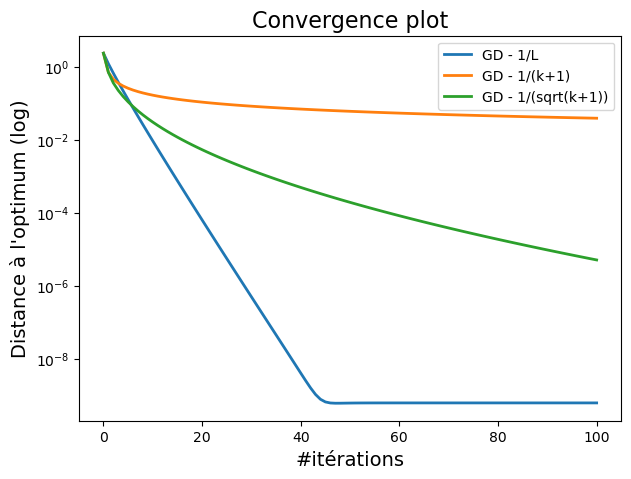

In [8]:
# Comparaison de trois variantes de descente de gradient 

# En termes de fonction objectif
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_lin, label="GD - 1/(k+1)", lw=2)
plt.semilogy(obj_c-f_min_lin, label="GD - 1/(sqrt(k+1))", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#itérations", fontsize=14)
plt.ylabel("Objectif (log)", fontsize=14)
plt.legend()

# En termes de distance à l'optimum
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="GD - 1/L", lw=2)
plt.semilogy(nits_b , label="GD - 1/(k+1)", lw=2)
plt.semilogy(nits_c, label="GD - 1/(sqrt(k+1))", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#itérations", fontsize=14)
plt.ylabel("Distance à l'optimum (log)", fontsize=14)
plt.legend()

# <span style="color:rgb(92,29,79)"> Partie 2 - Descente de gradient et minima locaux</span>

Dans cette partie, notre but est d'observer un résultat récente (établi en 2015) concernant la convergence de la descente de gradient. Il a en effet été démontré que la descente de gradient peut s'échapper de points stationnaires d'ordre 1 qui ne vérifient pas la condition d'optimalité à l'ordre deux **presque sûrement**.

## <span style="color:rgb(92,29,79)">2.1 Problème quadratique</span>

On considère le problème
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d}\ q(\mathbf{x}):=\frac{1}{2} \mathbf{x}^T \mathbf{A} \mathbf{x}
$$
où $\mathbf{A}$ est une matrice diagonale avec entrées $(1,\dots,1,-\lambda)$ sur la diagonale et $\lambda \in (0,1]$. On a alors $\|\mathbf{A}\|=1$.

### <span style="color:rgb(92,29,79)">Etude du problème</span>

- Ce problème est non bornée. En posant $\mathbf{x}=t\mathbf{e}_d$ (dernier vecteur de la base canonique dans $\mathbb{R}^d$) pour $t \in \mathbb{R}$, on obtient
$$
    q(\mathbf{x}) = -\frac{t^2}{2}\lambda \rightarrow -\infty \quad \mbox{lorsque} \quad t \rightarrow \pm \infty.
$$
La fonction n'a donc pas de minimum.
- La matrice hessienne de $q$ est $\nabla^2 q(\mathbf{x})=\mathbf{A}$, dont les valeurs propres sont $1$ and $-\lambda<0$. Par conséquent, $\mathbf{A}$ n'est pas semi-définie positive, et le problème est non convexe.
- Pour tout $\mathbf{x} \in \mathbb{R}^d$, on a 
$$
    \nabla q(\mathbf{x}) = \mathbf{A} \mathbf{x}.
$$
et le problème est de classe $\mathcal{C}^{1,1}_{\|\mathbf{A}\|}$.
- Le point $\mathbf{x}=\mathbf{0}$ vérifie $\nabla q(\mathbf{x})=\mathbf{0}$, mais sa matrice hessienne n'est pas semi-définie positive. Il s'agit donc d'un point stationnaire à l'ordre 1 mais pas à l'ordre 2.

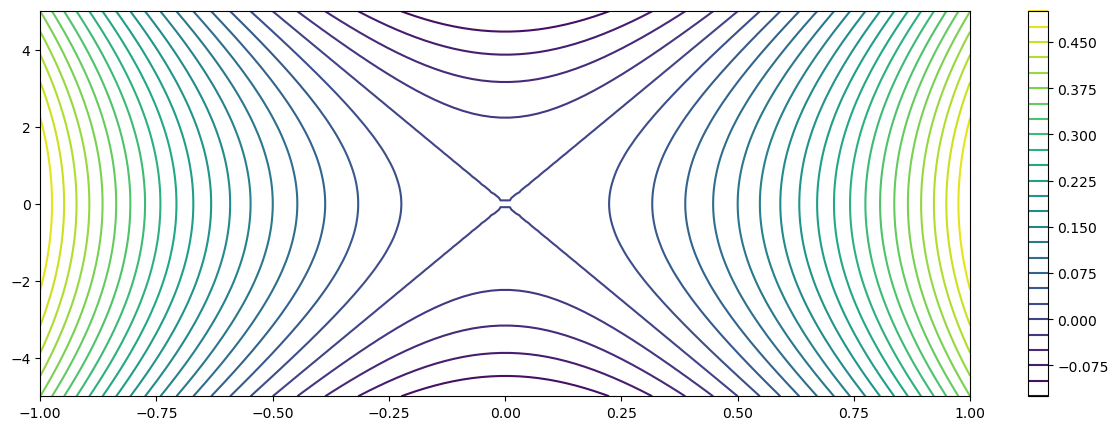

In [9]:
# Quantités auxiliaires
d = 2
lbda = 0.01

A = np.eye(d)
A[d-1,d-1] = -lbda

toy_f = lambda w : 0.5*w.dot(A.dot(w)) # Fonction objectif
toy_g = lambda w : A.dot(w) # Gradient




# Afficher les lignes de niveaux de la fonction objectif
if d==2:
    delta = 5
    w1 = np.linspace(-1,1,100)
    w2 = np.linspace(-delta,delta,100)
    fw = [[toy_f(np.array([u1,u2])) for u1 in w1] for u2 in w2]
    plt.figure(figsize=(15,5))
    plt.contour(w1,w2,fw,levels=30)
    plt.colorbar()

## <span style="color:rgb(92,29,79)">2.2 Application de la descente de gradient</span>

On considère une version simplifiée du code de descente de gradient de la partie 1.

In [10]:
def gd(x0,fun,gfun,step,n_iter=100, verbose=False): 
    """
        Code basique de descente de gradient
        
        Entrees:
            x0: Vecteur initial
            fun: Fonction objectif
            gfun: Vecteur gradient pour la fonction objectif
            step: Valeur de la longueur de pas
            n_iter: Nombre d'itérations
            verbose: Booléen réglant l'affichage des informations à chaque itération
      
        Sorties:
            x_output: Itéré final de la méthode
            objvals: Historique des valeurs de fonctions (tableau Numpy de taille n_iter)
            ngvals: Historique des normes de gradient (tableau Numpy de taille n_iter)
            
            
    """
    
    ############
    # Initialisation

    # Historique des valeurs de fonction
    objvals = []
    
    # Historique des normes de gradient
    ngvals = []
    
    # Valeur initiale de l'itéré courant   
    x = x0.copy()

    # Indice d'itération
    k=0    
    
    # Objectif au point initial
    obj = fun(x)
    objvals.append(obj)
    
    # Gradient au point initial
    g = gfun(x)
    ngrad = norm(g)
    ngvals.append(ngrad)

    # Affiche
    if verbose:
        print("Descente de gradient :")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))
    
    ####################
    # Boucle principale
    while (k < n_iter):
        
        # Calcul du gradient
        g = gfun(x)
        
        # Choix de la longueur de pas et mise à jour
        x[:] = x - step * g
        
        # Calcul de la nouvelle valeur d'objectif
        obj = fun(x)
        objvals.append(obj)
        
        # Calcul du nouveau gradient
        g = gfun(x)
        ngrad = norm(g)
        ngvals.append(ngrad)
        
        # Affichage
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))       
        
        # Incrémenter le nombre d'itérations de 1
        k += 1
    
    # Fin boucle principale
    ######################
    
    # Sorties
    x_output = x.copy()
    return x_output, np.array(objvals), np.array(ngvals)

Le script ci-dessous génére des points au hasard et observe si la fonction échappe au voisinage de l'origine (on 
considèrera que cela est le cas lorsque $f(\mathbf{x})<f(0)=0$.

- Il est possible de définir des points pour lesquels l'algorithme va converger vers l'origine. Il suffit en effet de considérer un vecteur dans l'espace engendré par les $d-1$ premiers vecteurs coordonnées : $\mathbf{x} \in \mbox{vect}\{\mathbf{e}_1,\dots,\mathbf{e}_{d-1}\}$,

**Compléter le code ci-dessous pour ajouter un tel point problématique, et valider l'implémentation.**

La descente de gradient a esquivé le point selle  10  fois sur  10  essais aléatoires
La descente de gradient a convergé vers le point selle en partant du point fixé


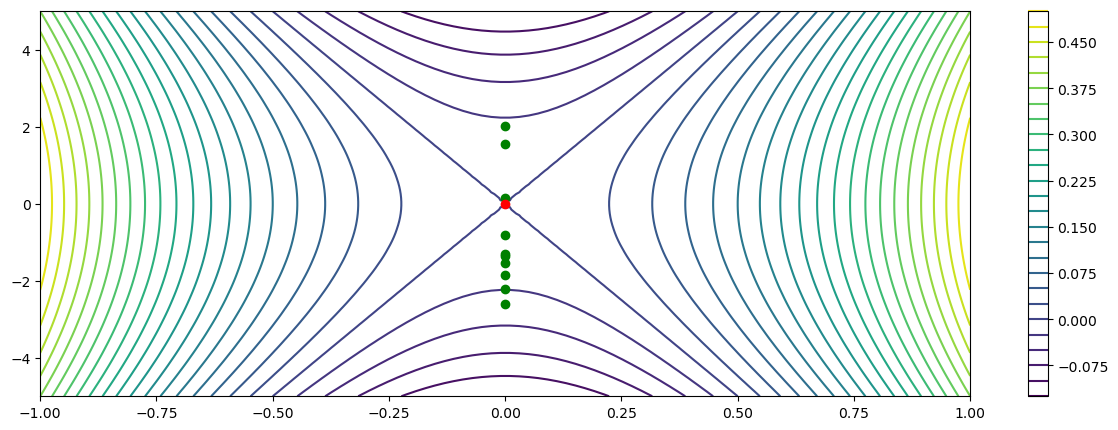

In [11]:
# Tester un ensemble de points initiaux au hasard

ntrials = 10

step = 1

# Booléen pour l'ajout d'un point problématique
#failpt = False
failpt = True

# Initialisation de structures
if failpt:
    Wf = np.zeros((ntrials+1,d))
    vf = np.zeros(ntrials+1)
else:
    Wf = np.zeros((ntrials,d))
    vf = np.zeros(ntrials)

# Compteur du nombre de bonnes exécutions (pour lesquelles on esquive l'origine)
goodtrials = 0

# Lancement des instances de l'algorithme
for i in range(ntrials):
    w0 = uniform([-1,-1],[1,1],size=d)
    Wf[i,:], obj_q, ngrad_q = gd(w0,toy_f,toy_g,step,100)
    vf[i] = obj_q[-1]
    if vf[i]<0:
        goodtrials += 1
        
# Ajout d'un point problématique pour la descente de gradient
if failpt:
    w0 = np.ones(d)
    w0[-1] = 0 # Pas de composante selon les vecteurs propres correspondant aux valeurs propres négatives
    Wf[ntrials,:], obj_q, ngrad_q = gd(w0,toy_f,toy_g,step,100)
    vf[ntrials] = obj_q[-1]
    if vf[ntrials]<0:
        goodfailpt = 1
    else:
        goodfailpt = 0
        
print('La descente de gradient a esquivé le point selle ',goodtrials,' fois sur ', ntrials,' essais aléatoires')
if goodfailpt:
    print('La descente de gradient a esquivé le point selle en partant du point fixé')
else:
    print('La descente de gradient a convergé vers le point selle en partant du point fixé')

    
# Affichage des resultats (uniquement en dimension 2)
if d==2:
    npts = vf.size
    plt.figure(figsize=(15,5))
    plt.contour(w1,w2,fw,levels=30)
    plt.colorbar()
    for i in range(npts):
        if vf[i]<0:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='green')
        else:
            plt.plot(Wf[i,0],Wf[i,1],'o',color='red')

# <span style="color:rgb(237,127,16)">Partie 3 (Bonus) - Descente de gradient et optimisation non convexe</span>

Dans cette dernière partie, nous allons appliquer l'algorithme de descente de gradient à une formulation 
non convexe issue des problèmes de complétion de matrice de rang faible.

## <span style="color:rgb(237,127,16)">3.1 Données</span>

On considère une matrice $\mathbf{M} \in \mathbb{R}^{d \times d}$ que l'on suppose symétrique semi-définie positive et *de rang faible* : cela signifie que $\mathbf{M}$ ne possède qu'un faible nombre $r \ll d$ de valeurs propres strictement positives et que toutes les autres sont nulles. Une telle matrice peut s'écrire sous la forme $\mathbf{M}=\mathbf{U}\mathbf{U}^T$ avec $\mathbf{U} \in \mathbb{R}^{d \times r}$

Notre but est de déterminer une approximatin de $\mathbf{M}$ au moyen d'un nombre limité d'observations $s$, produites par le code ci-dessous.

In [12]:
# Génération d'une matrice aléatoire de rang faible et échantillonnage
# Ce code est adapté d'un exercice proposé par Irène Waldspurger.

def datamatrix(d,r,nb_s):
    '''
        Génération d'une matrice aléatoire de rang faible et d'une version 
        échantillonnée de celle-ci.
        
        Entrées
            d: Dimension de la matrice (on considère des matrices de taille d x d
            r: Rang de la matrice
            nb_s: Nombre d'entrées échantillonnées
        
        Sortie:
            M: Matrice de données de taille d x d et de rang r
            S: Masque définissant les échantillons, matrice de taille d x d à coefficients dans {0,1}
            M_sampled: Matrice sous-échantillonnée
            U: Facteur ayant généré la matrice
    '''

    # Véritable facteur et matrice
    U = randn(d,r)
    M = np.dot(U,np.transpose(U))

    # Génération de la version sous-échantillonnée
    subset = choice(d*d,nb_s,replace=False)
    S = np.zeros(d*d)
    S[subset] = 1
    S = S.reshape((d,d))
    M_sampled = M*S # Produit de Hadamard pour NumPy

    return M,S,M_sampled,U


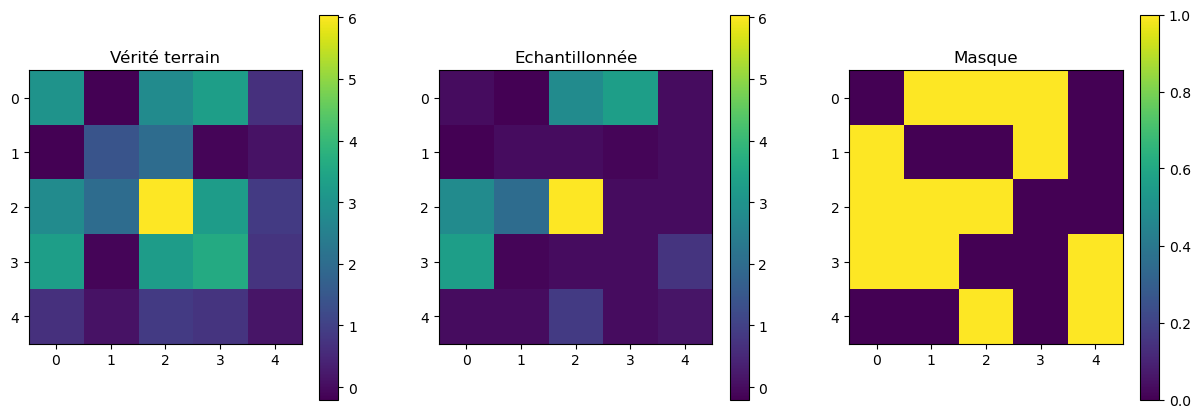

In [13]:
d = 5 # Taille de la matrice d*d
r = 2 # Rang
nb_s = 13 # Nombre d'entrées observées

# Paramètre du générateur de nombres aléatoires
np.random.seed(1)

M,S,M_sampled,U = datamatrix(d,r,nb_s)


# Affichage
plt.figure(figsize=(15,5))
plt.get_cmap('twilight')
plt.subplot(131)
plt.title('Vérité terrain')
plt.imshow(M)
plt.colorbar()
plt.subplot(132)
plt.title('Echantillonnée')
plt.imshow(M_sampled)
plt.colorbar()
plt.subplot(133)
plt.title('Masque')
plt.imshow(S)
plt.colorbar()

## <span style="color:rgb(237,127,16)">3.2 Formulations non convexes et dérivées</span>

On formule maintenant le problème de manière non convexe. Sachant que la solution s'exprime comme $\mathbf{U}\mathbf{U}^T$, on va cherche à approcher ce facteur plutôt que la matrice $\mathbf{M}$ elle-même (ce qui permet notamment de s'affranchir d'une formulation avec contraintes, et de manipuler moins de variables). On obtient ainsi le problème suivant :
$$
    \mathrm{minimiser}_{\mathbf{U} \in \mathbb{R}^{d \times r}} f(\mathbf{U}):=\frac{1}{2}\sum_{(i,j) \in \mathcal{S}} \left( [\mathbf{U}\mathbf{U}^T]_{ij}-\mathbf{M}_{ij}\right)^2.
$$
où $\mathcal{S} \subset \{1,\dots,d\}^2$ représente l'ensemble des entrées de la matrice de données $\mathbf{M}$ qui sont observées. Ce problème est sans contraintes sur ses $dr$ variables.



### <span style="color:rgb(237,127,16)">Approche matricielle</span>

Plutôt que d'effectuer une descente de gradient standard basée sur un vecteur de variables, on va définir le gradient de $f$ par rapport à la matrice $\mathbf{U}$, qui sera donc une matrice de $\mathbb{R}^{d \times r}$ (de 
même que dans le cas vectoriel, où $\nabla \phi(\mathbf{x}) \in \mathbb{R}^d$ pour toute fonction $\phi: \mathbb{R}^d \rightarrow \mathbb{R}$ et $\mathbf{x} \in \mathbb{R}^d$). Dans notre cas, le gradient est défini ainsi :
$$
    \forall \mathbf{U} \in \mathbb{R}^{d \times r}, \qquad 
    \nabla f(\mathbf{U}) := (\mathbf{E}+\mathbf{E}^T)\mathbf{U} \quad \mbox{where} \quad 
    \mathbf{E}:= (\mathbf{U}\mathbf{U}^T-\mathbf{M}) \otimes \mathbf{S},
$$
avec $\otimes$ le produit de Hadamard (produit des coefficients) et $\mathbf{S} \in \mathbb{R}^{d \times d}$ définie par
$$
    \mathbf{S}_{ij} = 
    \left\{
        \begin{array}{ll}
            1 &\mbox{si $(i,j) \in \mathcal{S}$} \\
            0 &\mbox{sinon.}
        \end{array}
    \right.
$$

*NB: On a $\nabla f(\mathbf{0})=\mathbf{0}$, la matrice nulle est donc un point stationnaire du problème.*

**Compléter l'implémentation des deux fonctions suivantes**
- Une fonction *f_mat* qui calcule la valeur de l'objectif;
- Une fonction *fg_mat* qui renvoie à la fois la valeur de l'objectif et celle du gradient matriciel.

In [14]:
# Fonctions du problème
def f_mat(U,M_S,S):
    '''
        Fonction objectif pour le problème de factorisation de matrice de rang faible.
        
        Entrées:
            U: matrice d x r (variables de décision)
            M_S: Echantillons de la matrice de données
            S: Masque d'échantillonnage
            
        Sortie:
            f: Valeur de la fonctionnelle de rang faible en U
    '''
    # A COMPLETER
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    f= 0.5*np.sum(E**2)
    # FIN A COMPLETER
    return f


def fg_mat(U,M_S,S):
    '''
        Fonction objectif et vecteur gradient pour le problème de factorisation de matrice de rang faible.
        
        Entrées:
            U: matrice d x r (variables de décision)
            M_S: Echantillons de la matrice de données
            S: Masque d'échantillonnage
            
        Sortie:
            f: Valeur de la fonctionnelle de rang faible en U
            G: Valeur du gradient de la fonctionnelle en U (défini comme une matrice)
    '''
    # A COMPLETER
    E = np.dot(U,np.transpose(U))-M_S
    E = E * S
    f = 0.5*np.sum(E**2)
    G = np.dot(E+np.transpose(E),U)
    # FIN A COMPLETER
    return f,G

On implémente maintenant une méthode de descente de gradient spécifique à ce problème. Pour chaque instance, on 
considère que
- l'instance a convergé vers un minimum global si $f(\mathbf{U}_K \mathbf{U}_K^T) \le 10^{-4}\|\mathbf{M}_S\|^2$;
- l'instance a convergé vers un point stationnaire si le test précédent échoue mais que 
$\nabla f(\mathbf{U}_K) \le 10^{-3}\|\mathbf{U}_K\|$;
- l'instance a échoué sinon.

In [15]:
def gd_matrix(U0,fun,fungrad,f_base,step,linesearch=False,n_iter=10000, verbose=False): 
    """
        Code de la descente de gradient pour la complétion de matrice de rang faible.
        
        Entrées:
            U0: Matrice initiale (rectangulaire)
            fun: Fonction objectif en U
            fungrad: Renvoie à la fois la fonction objectif et le gradient
            f_base: Valeur de base pour la convergence
            step: Valeur initiale de la longueur de pas
            linesearch: Booléen indiquant si une recherche linéaire est utilisée
            n_iter: Nombre maximum d'itérations
            verbose: Booléen d'affichage par itération
      
        Sorties:
            U_output: Itéré final de la méthode
            objvals: Historique des valeurs de fonctions (t as a Numpy array of length at most n_iter+1)
            ngvals: Historique des normes (output as a Numpy array of length at most n_iter+1)
            nits: Nombre d'itérations effectuées
            flag: Indicateur d'arrêt
                0: Convergence en termes de valeur de fonction (décroît f_base par un facteur 1e-4)
                1: Convergence en termes de norme de gradient (en dessous de 1e-3*norm(U_output))
                2: Nombre maximum d'itérations atteint
            
    """
    
    ############
    # Initialisation

    # Historique des fonctions objectifs
    objvals = []
    
    # Historique des normes de gradient
    ngvals = []
    
    # Valeur initiale de l'itéré courant  
    U = U0.copy()

    # Initialisation de l'indice d'itération
    k=0    
    
    # Valeurs courantes de l'objectif et de son gradient
    obj,G = fungrad(U)
    objvals.append(obj)
    ngrad = norm(G)
    ngvals.append(ngrad)

    # Affichage
    if verbose:
        print("Descente de gradient :")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))
    
    # Critère d'arrêt
    if (obj<=1e-4*f_base):
        flag=0
    elif (ngrad<=1e-3*norm(U)):
        flag=1
    else:
        flag=2
        
    stopping=(flag==2)
    
    ####################
    # Boucle principale
    while stopping:
        
        # Choix de la longueur de pas
        if linesearch:
            if k>0:
                step = 1.1*step
            fval = fun(U-step*G)
            ngrad2 = ngrad**2
            # Boucle de recherche linéaire pour calculer une longueur de pas
            while (fval-obj>-0.5*step*ngrad2):
                step = step/2
                fval = fun(U-step*G)
        
        U = U - step * G
        
        # Calcul de l'objectif et du gradient
        obj,G = fungrad(U)
        objvals.append(obj)
        ngrad = norm(G)
        ngvals.append(ngrad)
        
        # Affichage
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % ngrad).rjust(8)]))       
        
        # Incrément de l'indice d'itération
        k += 1
        
        # Critère d'arrêt
        if (obj<=1e-4*f_base):
            flag=0
        elif (ngrad<=1e-3*norm(U)):
            flag=1
        else:
            flag=2
        stopping = (flag==2)
    
    # Fin de la boucle principale
    ######################
    
    # Fin de l'algorithme
    U_output = U.copy()
    nits = k
        
    return U_output, np.array(objvals), np.array(ngvals),nits,flag

0
Fonction objectif normalisée: 3.294970662944837e-05
Norme de gradient normalisée: 0.016902753742291565


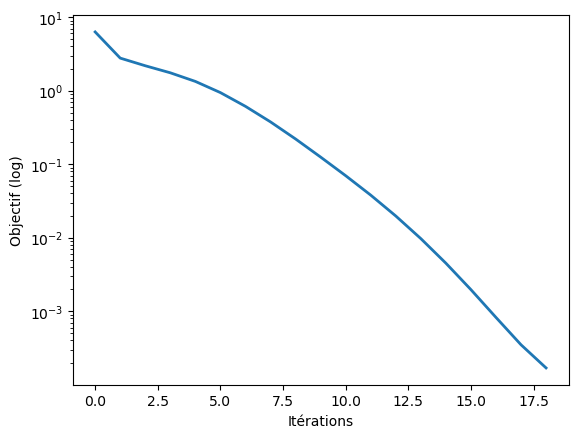

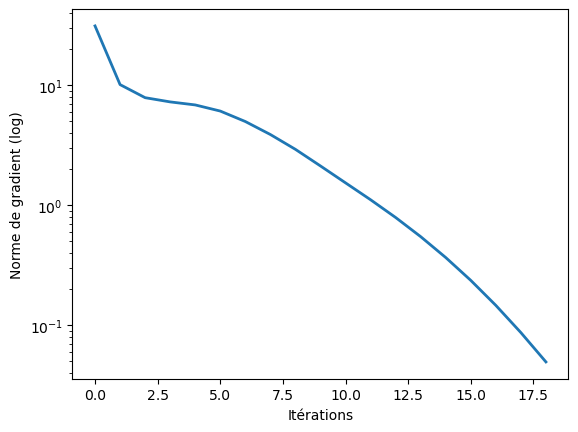

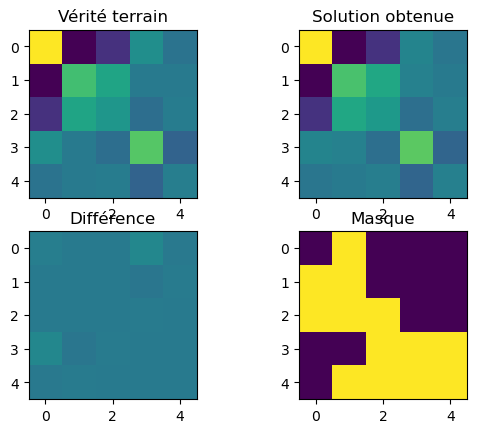

In [16]:
# Validation sur un petit exemple

d=5
r=2
nb_s=13

M,S,M_s,U_star = datamatrix(d,r,nb_s)

fbase = 0.5*(np.sum(M_s**2))

# Tester la descente de gradient
U0 = randn(d,r)
#U0 = U_star
U_out,obj_out,ng_out,nits,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),fbase,1.,True,10000,False)

#print(nits)
print(flag)
# Résultats finaux
print("Fonction objectif normalisée:",obj_out[-1]/(norm(M_s)**2))
print("Norme de gradient normalisée:",ng_out[-1]/norm(U_out))
M_out = np.dot(U_out,np.transpose(U_out))

plt.figure(1)
plt.semilogy(obj_out/norm(M_s), lw=2)
plt.xlabel('Itérations')
plt.ylabel('Objectif (log)')
plt.figure(2)
plt.semilogy(ng_out, lw=2)
plt.xlabel('Itérations')
plt.ylabel('Norme de gradient (log)')
plt.figure(3)
plt.subplot(221)
plt.title('Vérité terrain')
plt.imshow(M)
plt.subplot(222)
plt.title('Solution obtenue')
plt.imshow(M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(223)
plt.title('Différence')
plt.imshow(M-M_out,vmin=np.amin(M_out),vmax=np.amax(M_out))
plt.subplot(224)
plt.title('Masque')
plt.imshow(S)

On compare finalement la qualité de la solution obtenue pour différentes valeurs du nombre d'échantillons.

10 - 
12 - 
14 - 
16 - 
18 - 
20 - 
22 - 
24 - 
26 - 
28 - 
30 - 
32 - 
34 - 
36 - 
38 - 


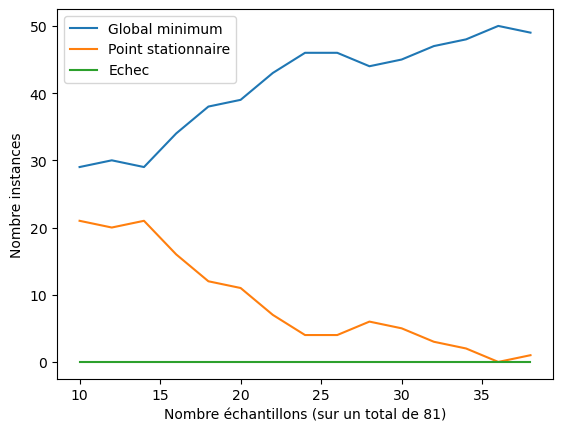

In [17]:
# Tester plusieurs instances

d=9
r=1
vals_s = range(10,40,2)
len_s = len(vals_s)
counter = np.zeros((len_s,3))
#
for n_it in range(0,len_s):
    nb_s = vals_s[n_it]
    print(str(nb_s) + ' - '),
    for i in range(0,50):
        M,S,M_s,U_star = datamatrix(d,r,nb_s)
        nMs2 = 0.5*norm(M_s)**2
        U0 = randn(d,r)
        U_out,obj_out,ng_out,_,flag = gd_matrix(U0,lambda U: f_mat(U,M_s,S),lambda U: fg_mat(U,M_s,S),nMs2,1.,True,20000,False)
        counter[n_it,flag]+=1
#
plt.xlabel('Nombre échantillons (sur un total de '+str(d**2)+')')
plt.ylabel('Nombre instances')
plt.plot(vals_s,counter[:,0],label='Global minimum')
plt.plot(vals_s,counter[:,1],label='Point stationnaire')
plt.plot(vals_s,counter[:,2],label='Echec')
plt.legend()

In [18]:
## Version 1.0 - C. W. Royer, octobre 2022.